In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')
import bs4
from bs4 import BeautifulSoup
import requests
import re
import json
from __future__ import division
from difflib import get_close_matches
from datetime import date
import datetime
from datetime import datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, \
precision_score, recall_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cross_validation import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,\
AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
from math import log
import pickle
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
# load cleaned data from EDA - this includes all outcomes
with open('sub.pkl', 'r') as picklefile:
    sub = pickle.load(picklefile)
# create subset of only adopted dogs
adopt = sub[sub["outcome"]=="Adoption"]

In [3]:
len(adopt)

8903

In [4]:
# only use dogs that have names
adopt = adopt[adopt["missing_name"]==0]
# drop features not needed for predictions 
adopt.drop(['ID', 'in_date', 'out_date','outcome','outcome_sub','breed_list_corrected','name','missing_name'],inplace=True,axis=1)
# convert categorical features to dummies, drop column for least common occurrence
def add_dummies(var,df):
    drops =  df[var].value_counts().sort_values().index[0]
    df = df.join(pd.get_dummies(df[var]))
    df.drop(var, axis=1, inplace=True)
    return df
adopt = add_dummies("in_type",adopt)
adopt = add_dummies("in_condition",adopt)
adopt = add_dummies("colour",adopt)
adopt = add_dummies("month_in",adopt)

In [5]:
# remove potentially colinear features: check energy / exercise and coat / groom
print adopt.corr().loc["energy",:].sort_values(ascending=False).head(2)
print adopt.corr().loc["coat",:].sort_values(ascending=False).head(2)

energy      1.000000
exercise    0.927657
Name: energy, dtype: float64
coat     1.000000
groom    0.591265
Name: coat, dtype: float64


In [6]:
# energy and exercise are high correlated, so one should be removed.  coat and groom are not that highy correlated
print np.corrcoef(adopt["energy"],adopt["shelter_time"])[0][1], np.corrcoef(adopt["exercise"],adopt["shelter_time"])[0][1]
#energy is slightly more highly correlated with outcome so drop exercise feature
adopt.drop("exercise", axis=1, inplace=True)

0.130946144981 0.118085276997


In [7]:
#check features related to name popularity
name_cols = ['F1970', 'M2000', 'M1970', 'F1890', 'M1990',
       'F1990', 'M1930', 'M1910', 'F1910', 'M1880', 'M1950', 'F1950',
       'F1930', 'F2000', 'F2010', 'F1880', 'M1960', 'M2010', 'F1960',
       'F1980', 'M1980', 'M1890', 'F1920', 'F1900', 'M1900', 'F1940',
       'M1940', 'M1920']
name_cols = sorted(name_cols)
adopt.loc[:,name_cols].corr().head()

,F1880,F1890,F1900,F1910,F1920,F1930,F1940,F1950,F1960,F1970,...,M1920,M1930,M1940,M1950,M1960,M1970,M1980,M1990,M2000,M2010
F1880,1.000000,0.927090,0.857204,0.650069,0.409629,0.288979,0.211003,0.071227,-0.006711,0.037373,...,0.004385,0.007648,0.004163,0.003506,-0.025805,-0.021997,-0.024408,-0.029140,-0.039847,-0.044452
F1890,0.927090,1.000000,0.931143,0.721504,0.497671,0.361480,0.195000,0.070464,-0.006936,0.014389,...,0.003920,0.007183,0.003699,0.003041,-0.025983,-0.022149,-0.024576,-0.029341,-0.040123,-0.044759
F1900,0.857204,0.931143,1.000000,0.797820,0.582241,0.432125,0.245005,0.116576,-0.006666,0.014887,...,0.004479,0.007742,0.004257,0.003600,-0.025769,-0.021967,-0.024374,-0.029100,-0.039792,-0.044390
F1910,0.650069,0.721504,0.797820,1.000000,0.759252,0.589189,0.378608,0.212650,-0.001745,0.024296,...,0.014878,0.018185,0.014654,0.013991,-0.022122,-0.018858,-0.020924,-0.024981,-0.034160,-0.038107
F1920,0.409629,0.497671,0.582241,0.759252,1.000000,0.787902,0.515672,0.324766,0.023212,0.036979,...,0.028498,0.031971,0.028264,0.027571,-0.018254,-0.015561,-0.017266,-0.020614,-0.028188,-0.031445


In [8]:
# very correlated to nearby decades - take every other decade
drop_cols = []
for i, j in enumerate(name_cols):
    if i%2==0:
        drop_cols.append(j)
adopt.drop(drop_cols, axis=1,inplace=True)

### Outlier Analysis

count    7641.000000
mean       26.401518
std        46.438568
min         0.000000
25%         5.000000
50%         9.000000
75%        28.000000
max       637.000000
Name: shelter_time, dtype: float64
95th percentile 105.0


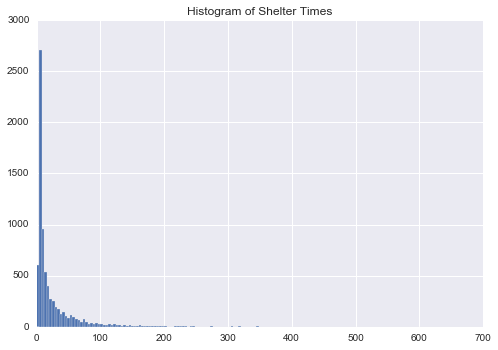

In [9]:
# plot distribution of shelter times to look for outliers
adopt["shelter_time"].hist(bins=range(0,700,4))
plt.title("Histogram of Shelter Times")
print adopt["shelter_time"].describe()
print "95th percentile", adopt["shelter_time"].quantile(0.95)

The distribution shows a long right tail. Although the max value is ~640, 95% fall below 105 so in order not to skew the models to the outliers, any dog in the shelter longer than 105 days is dropped.

In [10]:

# remove data where shelter time is >= 105 (roughly 5% of the data)
adopt= adopt[adopt["shelter_time"]<105]
print len(adopt), "records remaining"

7256 records remaining


### Regression Models

In [11]:
# initialize cross val with 5 folds, create train / test split (70/30 split)
cv = KFold(len(adopt),5,shuffle=True, random_state=3)
x = adopt.drop(["shelter_time"], axis=1)
y = adopt["shelter_time"]
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=0.30,
                                                        random_state=14)

In [12]:

# basic comparison of regressor models 
def reg_model(model, model_name, x, y, cv):
    mod = model
    mod.fit(x,y)
    m = np.mean(cross_val_score(model,x,y,cv=cv))
    s = np.std(cross_val_score(model,x,y,cv=cv))
    print("{} mean r2 score from cross validation:\t{:0.3} ± {:0.3}".format(model_name,round(m,3), round(s,3)))

model_dict = {"linear regression":LinearRegression(), "decision tree": DecisionTreeRegressor(max_depth=5),\
             "random forest": RandomForestRegressor(max_depth=5), \
              "gradient boosting": GradientBoostingRegressor(max_depth=5),\
             "adaboost": AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5))}

for k, i in model_dict.iteritems():
    reg_model(i, k,x,y,cv)   

decision tree mean r2 score from cross validation:	0.187 ± 0.008
adaboost mean r2 score from cross validation:	-0.463 ± 0.214
random forest mean r2 score from cross validation:	0.211 ± 0.015
gradient boosting mean r2 score from cross validation:	0.241 ± 0.013
linear regression mean r2 score from cross validation:	-6.14e+14 ± 1.21e+15


In [13]:
# model performance is fairly poor, try using log time and log age instead
adopt["time_log"] = adopt["shelter_time"].apply(lambda x: 0 if x==0 else log(x))
adopt["age_log"] = adopt["in_age"].apply(lambda x: 0 if x==0 else log(x))

In [14]:
# re-initialize cross val with 5 folds, create train / test split (70/30 split), using log transformed vars
cv = KFold(len(adopt),5,shuffle=True, random_state=3)
x = adopt.drop(["shelter_time","time_log","in_age"], axis=1)
y = adopt["time_log"]
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=0.30,
                                                        random_state=14)

In [18]:
# redo comparison
for k, i in model_dict.iteritems():
    reg_model(i, k,x,y,cv)   

decision tree mean accuracy score from cross validation:	0.235 ± 0.021
adaboost mean accuracy score from cross validation:	0.133 ± 0.019
random forest mean accuracy score from cross validation:	0.253 ± 0.016
gradient boosting mean accuracy score from cross validation:	0.319 ± 0.016
linear regression mean accuracy score from cross validation:	-3.44e+14 ± 5.58e+14



Using the log of time as the target, and the log of age as a predictor, improves model performance slightly.

In [16]:
# grid search on gradient boost, which was best performing base model - done outside notebook, results pasted below
# grad = GradientBoostingRegressor(n_estimators=100)
# params = {"max_depth": [1,3,5,10],"min_samples_split": [2,5], "min_samples_leaf": [2,5], "subsample":[0.3,0.7,1.0],\
#          "max_features": [0.2,0.5,0.9], "alpha":[0.1,0.3,0.5,0.7,0.9]}

# grid_grad = GridSearchCV(grad, params, n_jobs=-1, verbose=True, cv=cv)
# grid_grad.fit(x,y)

# {'alpha': 0.1,
#  'max_depth': 5,
#  'max_features': 0.9,
#  'min_samples_leaf': 5,
#  'min_samples_split': 2,
#  'subsample': 0.7}

In [17]:
grad = GradientBoostingRegressor(n_estimators=100,alpha=0.1, max_depth=5, max_features=0.9, min_samples_leaf=5, \
                                min_samples_split = 2, subsample = 0.7)
reg_model(grad, "gradient boost", x, y, cv)

gradient boost mean accuracy score from cross validation:	0.323 ± 0.016


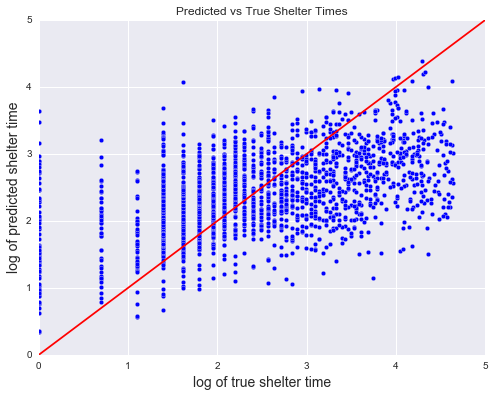

In [19]:
# check how well the model predicts on train / test set
grad.fit(X_train,y_train)
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(x=y_test,y=grad.predict(X_test))
plt.plot([0,5],[0,5], color="r")
ax.set(xlim=[0,5], ylim=[0,5])
ax.set_xlabel("log of true shelter time",fontsize=14)
ax.set_ylabel("log of predicted shelter time",fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Predicted vs True Shelter Times")

Grid searching improved the average r2 score for the cross-validation to a little over 0.32, but as the chart above shows, the model appers to be underpredicting time for those dogs in the shelter for a long time, and overpredicted for those dogs in the shelter for a short time.

In [20]:
#print out top 10 feature importances
grad.fit(x,y)
fi = pd.DataFrame(grad.feature_importances_.T)
fi["feature"] = x.columns
fi.sort_values(0, ascending = False).head(10)

,0,feature
225,0.162818,age_log
1,0.136468,total_number_dogs
196,0.035284,Owner Surrender
14,0.029963,size
2,0.027726,in_neuter
15,0.024244,coat
202,0.024109,Normal
175,0.015491,aggressive
16,0.013609,groom
0,0.013223,in_sex



Dog's age and the total number of dogs in the shelter at the time of entry into the shelter have the highest importance. No name-related feature appears in the top 10 more important features.

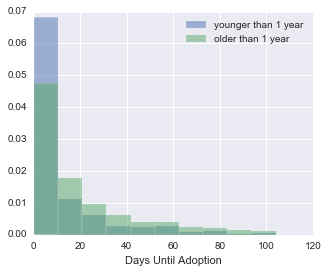

In [21]:
age = (adopt["in_age"]<1)
fig, ax = plt.subplots(figsize=(5,4))
adopt[age]["shelter_time"].hist(alpha = 0.5, normed=True, label = "younger than 1 year")
adopt[~age]["shelter_time"].hist(alpha = 0.5, normed=True, label = "older than 1 year")
plt.legend()
ax.set_xlabel("Days Until Adoption")

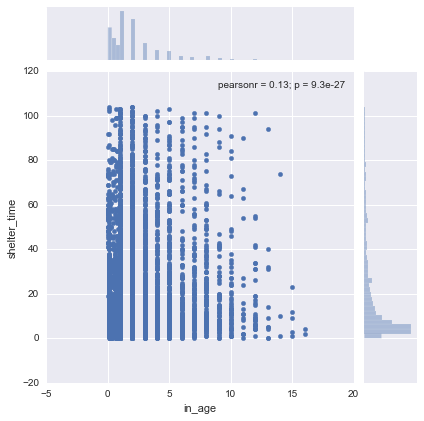

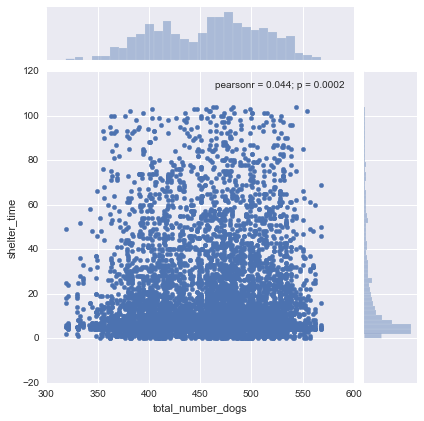

In [22]:
sns.jointplot(adopt["in_age"], adopt["shelter_time"])
sns.jointplot(adopt["total_number_dogs"], adopt["shelter_time"])


The scatter charts above show the relationship between age and number of dogs in the shelter, and the time to adoption. The charts suggest that dogs who are older take longer to be adopted, and when there are more dogs in the shelter, a given dog spends longer in the shelter until adoption. But in both cases, the relationships look somewhat weak and possibly not linear which may explain why the regression model performs relatively poorly. In other words, the relationship between the features and shelter time may change as the values for the features change.

Since the regression models are underpredicting time for dogs in the shelter a long time, and overpredicting for those who get out quickly, a classification model might work better. A classification model is explored, splitting the dogs into tertiles by time in shelter.

In [23]:
#split into tertiles

print "first tertile:", adopt["shelter_time"].quantile(0.33)
print "second tertile:",adopt["shelter_time"].quantile(0.67)
def classify_time(x):
    if x <= adopt["shelter_time"].quantile(0.33):
        return 0
    elif x <= adopt["shelter_time"].quantile(0.67):
        return 1
    else:
        return 2
adopt["time_class"] = adopt["shelter_time"].apply(classify_time)
adopt["time_class"].value_counts() / len(adopt)

first tertile: 5.0
second tertile: 16.0


1    0.343716
0    0.333241
2    0.323043
Name: time_class, dtype: float64

In [24]:
# initialize cross validation folds (5 folds)
cv_class = StratifiedKFold(adopt["time_class"],n_folds=5,shuffle=True, random_state=3)
x_class = adopt.drop(["shelter_time", "time_log","time_class", "in_age"], axis=1)
y_class = adopt["time_class"]
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(x_class, y_class, 
                                                        test_size=0.30,
                                                        random_state=15, stratify=y_class)

In [25]:
# basic comparison of classification models 
def class_model(model, model_name, x, y, cv):
    mod = model
    mod.fit(x,y)
    m = np.mean(cross_val_score(model,x,y,cv=cv))
    s = np.std(cross_val_score(model,x,y,cv=cv))
    print("{} mean r2 score from cross validation:\t{:0.3} ± {:0.3}".format(model_name,round(m,3), round(s,3)))

class_model_dict = {"logistic regression":LogisticRegression(), "decision tree": DecisionTreeClassifier(max_depth=5),\
             "random forest": RandomForestClassifier(max_depth=5), \
              "gradient boosting": GradientBoostingClassifier(max_depth=5),\
             "adaboost": AdaBoostClassifier(), "SVM": SVC()}    
    
for k, i in class_model_dict.iteritems():
    class_model(i, k,x_class,y_class,cv_class) 

SVM mean r2 score from cross validation:	0.471 ± 0.008
decision tree mean r2 score from cross validation:	0.507 ± 0.006
gradient boosting mean r2 score from cross validation:	0.553 ± 0.006
adaboost mean r2 score from cross validation:	0.535 ± 0.013
logistic regression mean r2 score from cross validation:	0.508 ± 0.012
random forest mean r2 score from cross validation:	0.483 ± 0.012


             precision    recall  f1-score   support

          0       0.59      0.61      0.60       725
          1       0.44      0.45      0.45       748
          2       0.61      0.57      0.59       703

avg / total       0.54      0.54      0.54      2176



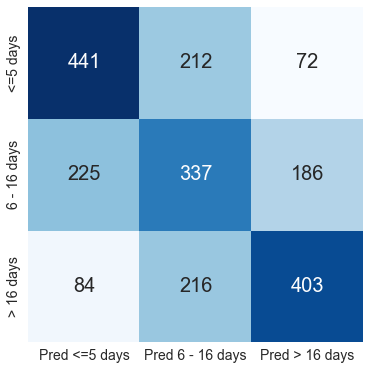

In [26]:
grad_class = GradientBoostingClassifier(max_depth=5)
grad_class.fit(X_train_class,y_train_class)
conmat = np.array(confusion_matrix(y_test_class, grad_class.predict(X_test_class)))
confusion = pd.DataFrame(conmat, index=['<=5 days', '6 - 16 days', '> 16 days'],\
                     columns=['Pred <=5 days', 'Pred 6 - 16 days', 'Pred > 16 days'])

plt.figure(figsize = (6,6))
heat = sns.heatmap(confusion, annot=True, annot_kws={"size": 20},cmap='Blues',fmt='g', cbar=False)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
# plt.title("Confusion Matrix", fontsize=20)
print classification_report(y_test_class, grad_class.predict(X_test_class))

Overall accuracy is fairly low, and particularly it looks like the model is predicting with reasonable accuracy those dogs in the shelter fewer than 5 days, and those in the shelter longer than 16. Those in between are being misclassified at a higher rate. Given this, the data will be divided into those dogs who are adopted within 8 days (roughly half) and those who are adopted after 8 days.

In [27]:

# reassign time class into two categories: split at median
print "median:", adopt["shelter_time"].median()
adopt["time_class"] = adopt["shelter_time"].apply(lambda x: 1 if x<=adopt["shelter_time"].median() else 0)
adopt["time_class"].value_counts() / len(adopt)

median: 8.0


1    0.500827
0    0.499173
Name: time_class, dtype: float64

In [28]:
#initialize cross val folds
cv_class = StratifiedKFold(adopt["time_class"],n_folds=5,shuffle=True, random_state=3)
x_class = adopt.drop(["shelter_time", "time_log","time_class", "in_age"], axis=1)
y_class = adopt["time_class"]
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(x_class, y_class, 
                                                        test_size=0.30,
                                                        random_state=48, stratify=y_class)
# #test basic model score
for k, i in class_model_dict.iteritems():
    reg_model(i, k,x_class,y_class,cv_class) 

SVM mean accuracy score from cross validation:	0.654 ± 0.015
decision tree mean accuracy score from cross validation:	0.68 ± 0.008
gradient boosting mean accuracy score from cross validation:	0.721 ± 0.009
adaboost mean accuracy score from cross validation:	0.7 ± 0.01
logistic regression mean accuracy score from cross validation:	0.684 ± 0.01
random forest mean accuracy score from cross validation:	0.664 ± 0.015


In [29]:
# grid search for gradient boosting
# grid search in terminal
# grad = GradientBoostingClassifier(n_estimators=100)
# params = {"max_depth": [1,3,5,10],"min_samples_split": [2,5], "min_samples_leaf": [2,5], "subsample":[0.3,0.7,1.0],\
#          "max_features": [0.2,0.5,0.9]}

# grid_grad = GridSearchCV(grad, params, n_jobs=-1, verbose=True, cv=cv)
# grid_grad.fit(x,y)

# print grid_grad.best_params_
# {'max_features': 0.2, 'min_samples_split': 5, 'subsample': 1.0, 'max_depth': 10, 'min_samples_leaf': 5}
grad_class = GradientBoostingClassifier(n_estimators=100,max_features=0.2,min_samples_split=5,\
                                        subsample=1,max_depth=10,min_samples_leaf=5)
class_model(grad_class, "gradient boost", x_class, y_class, cv_class)

gradient boost mean r2 score from cross validation:	0.713 ± 0.01


             precision    recall  f1-score   support

          0       0.73      0.74      0.73      1087
          1       0.73      0.73      0.73      1090

avg / total       0.73      0.73      0.73      2177



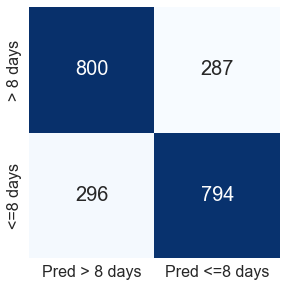

In [30]:
grad_class.fit(X_train_class,y_train_class)
conmat = np.array(confusion_matrix(y_test_class, grad_class.predict(X_test_class)))
confusion = pd.DataFrame(conmat, index=['> 8 days','<=8 days'],\
                     columns=['Pred > 8 days','Pred <=8 days'])

plt.figure(figsize = (4.5,4.5))
heat = sns.heatmap(confusion, annot=True, annot_kws={"size": 20},cmap='Blues',fmt='g', cbar=False)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
# plt.title("Confusion Matrix", fontsize=20)
print classification_report(y_test_class, grad_class.predict(X_test_class))

With two classes, the model performs better and predicts with roughly 73% accuracy.

In [31]:
#print out to 10 feature importances
grad_class.fit(x_class,y_class)
fi_class = pd.DataFrame(grad_class.feature_importances_.T)
fi_class["feature"] = x_class.columns
fi_class.sort_values(0, ascending = False).head(20)

,0,feature
1,0.152236,total_number_dogs
225,0.146326,age_log
15,0.025772,coat
14,0.023339,size
0,0.023323,in_sex
194,0.023157,word_name
208,0.020951,dark mix
13,0.019578,energy
2,0.019140,in_neuter
176,0.017815,cute_name



Again, age and number of other dogs in the shelter on intake ar ethe most important features. Four name-related features appear in the top 20 list of feature importance, suggesting they can, to some extent, help to predict the dog's outcome.

A shelter might want to find a higher proportion of the at-risk dogs (those dogs who take longer than 8 days to be adopted). In order to do this, we can change the decision threshold to increase the recall (but at expense of precision).

In [73]:
#check frequecy of breeds
breeds_keep = list(adopt.iloc[:,19:177].columns[adopt.iloc[:,19:177].apply(sum, axis=0).values>19])
breeds_used = list(adopt.iloc[:,19:177].columns)
breeds_drop = [b for b in breeds_used if b not in breeds_keep]

In [144]:
#dropt anything with fewer than 20 dogs
adopt_sub = adopt.drop(breeds_drop, axis=1)
adopt_sub.drop(["time_log","in_age"], axis=1, inplace=True)

In [145]:
#re-initialize cross val folds
cv_class = StratifiedKFold(adopt_sub["time_class"],n_folds=5,shuffle=True, random_state=3)
x_class = adopt_sub.drop(["time_class","shelter_time"], axis=1)
y_class = adopt_sub["time_class"]
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(x_class, y_class, 
                                                        test_size=0.30,
                                                        random_state=48, stratify=y_class)

In [146]:
grad_class = GradientBoostingClassifier(n_estimators=100,max_features=0.2,min_samples_split=5,\
                                        subsample=1,max_depth=10,min_samples_leaf=5)
class_model(grad_class, "gradient boost", x_class, y_class, cv_class)

gradient boost mean r2 score from cross validation:	0.713 ± 0.012


             precision    recall  f1-score   support

          0       0.72      0.72      0.72      1087
          1       0.72      0.73      0.72      1090

avg / total       0.72      0.72      0.72      2177



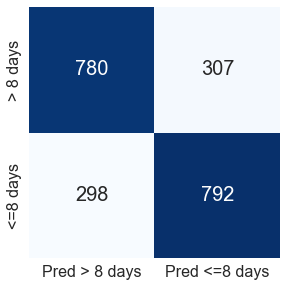

In [147]:
grad_class.fit(X_train_class,y_train_class)
conmat = np.array(confusion_matrix(y_test_class, grad_class.predict(X_test_class)))
confusion = pd.DataFrame(conmat, index=['> 8 days','<=8 days'],\
                     columns=['Pred > 8 days','Pred <=8 days'])

plt.figure(figsize = (4.5,4.5))
heat = sns.heatmap(confusion, annot=True, annot_kws={"size": 20},cmap='Blues',fmt='g', cbar=False)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
# plt.title("Confusion Matrix", fontsize=20)
print classification_report(y_test_class, grad_class.predict(X_test_class))

In [164]:
#print out to 10 feature importances
grad_class.fit(x_class,y_class)
fi_class = pd.DataFrame(grad_class.feature_importances_.T)
fi_class["feature"] = x_class.columns
fi_class.sort_values(0, ascending = False).head(10)

,0,feature
125,0.160513,age_log
1,0.156408,total_number_dogs
14,0.026476,size
15,0.025659,coat
94,0.022089,word_name
0,0.021649,in_sex
108,0.020571,dark mix
2,0.020411,in_neuter
13,0.020397,energy
76,0.019682,cute_name


In [169]:
# take only top 30 features by FI
sub_vars = list(fi_class.sort_values(0, ascending = False).head(30)["feature"])
sub_vars.append("time_class")
sub_vars.append("shelter_time")

In [170]:
print sub_vars

['age_log', u'total_number_dogs', 'size', 'coat', 'word_name', u'in_sex', 'dark mix', 'in_neuter', 'energy', 'cute_name', 'groom', 'Normal', 'Stray', 'light mix', 'popular_shelter_name', 'human_name', 'Owner Surrender', 4, 'popular_dog_name', 'sporting', 'herding', 'toy', 'light', 6, 'other', 3, 'Public Assist', 11, 'chihuahua', 'aggressive', 'time_class', 'shelter_time']


In [171]:
adopt_sub = adopt_sub[sub_vars]

In [258]:
#re-initialize cross val folds
cv_class = StratifiedKFold(adopt_sub["time_class"],n_folds=5,shuffle=True, random_state=3)
x_class = adopt_sub.drop(["time_class","shelter_time"], axis=1)
y_class = adopt_sub["time_class"]
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(x_class, y_class, 
                                                        test_size=0.30,
                                                        random_state=48, stratify=y_class)

In [261]:
grad_class = GradientBoostingClassifier(n_estimators=50,max_features=0.2,min_samples_split=5,\
                                        subsample=1,max_depth=10,min_samples_leaf=5)
class_model(grad_class, "gradient boost", x_class, y_class, cv_class)

gradient boost mean r2 score from cross validation:	0.707 ± 0.008


Simpler model with only 30 features still performs with roughly 70% accuracy.

             precision    recall  f1-score   support

          0       0.72      0.72      0.72      1087
          1       0.72      0.72      0.72      1090

avg / total       0.72      0.72      0.72      2177



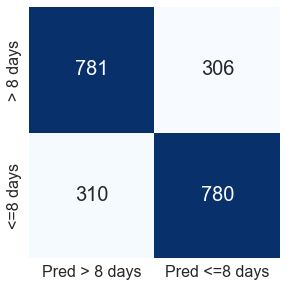

In [260]:
grad_class.fit(X_train_class,y_train_class)
conmat = np.array(confusion_matrix(y_test_class, grad_class.predict(X_test_class)))
confusion = pd.DataFrame(conmat, index=['> 8 days','<=8 days'],\
                     columns=['Pred > 8 days','Pred <=8 days'])

plt.figure(figsize = (4.5,4.5))
heat = sns.heatmap(confusion, annot=True, annot_kws={"size": 20},cmap='Blues',fmt='g', cbar=False)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
# plt.title("Confusion Matrix", fontsize=20)
print classification_report(y_test_class, grad_class.predict(X_test_class))

             precision    recall  f1-score   support

          0       0.67      0.81      0.74      1087
          1       0.76      0.61      0.68      1090

avg / total       0.72      0.71      0.71      2177



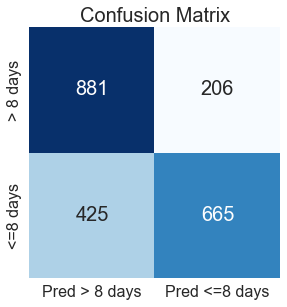

In [175]:
# adjust probability threshold to find higher proportion of at risk dogs - these are the ones that the shelter will want
# to focus on, and would probably give up overall accuracy to find them

y_pred_prob = grad_class.predict_proba(X_test_class)
y_pred_thresh = [1 if i <= 0.40 else 0 for i in y_pred_prob.T[0]]
print classification_report(y_test_class, y_pred_thresh)

conf = confusion_matrix(y_test_class, y_pred_thresh)
conmat = np.array(confusion_matrix(y_test_class, y_pred_thresh))
confusion = pd.DataFrame(conmat, index=['> 8 days','<=8 days'],\
                     columns=['Pred > 8 days','Pred <=8 days'])

plt.figure(figsize = (4.5,4.5))
heat = sns.heatmap(confusion, annot=True, annot_kws={"size": 20},cmap='Blues',fmt='g', cbar=False)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.title("Confusion Matrix", fontsize=20)

Moving the threshold increases the recall for at-risk dogs to 81%, but decreases the precision to 67%.

In [256]:
#save out model for use in app
grad_class.fit(x_class,y_class)
# with open('classif.pkl', 'w') as picklefile:
#     pickle.dump(grad_class, picklefile)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=10, max_features=0.2, max_leaf_nodes=None,
              min_samples_leaf=5, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1, verbose=0,
              warm_start=False)

### Surival Analysis

Given that the target variable is an event over time from intake, survival analysis is also used to explore the relationships between the features and time to adoption.

In [118]:
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import AalenAdditiveFitter
from lifelines.statistics import logrank_test

In [193]:
adopt_sub1 = adopt_sub.drop("time_class", axis=1)

[<matplotlib.text.Text at 0x1217e4310>, <matplotlib.text.Text at 0x121861290>]

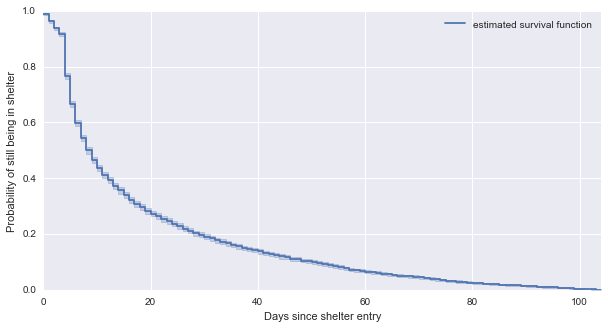

In [194]:
# plot survival curve
kmf = KaplanMeierFitter()
T = adopt_sub1["shelter_time"]
kmf.fit(T, label = "estimated survival function")

fig, ax = plt.subplots(1,1,figsize=(10,5))

kmf.plot(kind="line",ax=ax,)
ax.set(xlabel="Days since shelter entry", ylabel="Probability of still being in shelter")


The chart above shows the estimated survival curve for the full set of adopted dogs. The value on the vertical axis represents the probability that the dog is still in the shelter at time t (i.e. has not yet been adopted).

(0, 1)

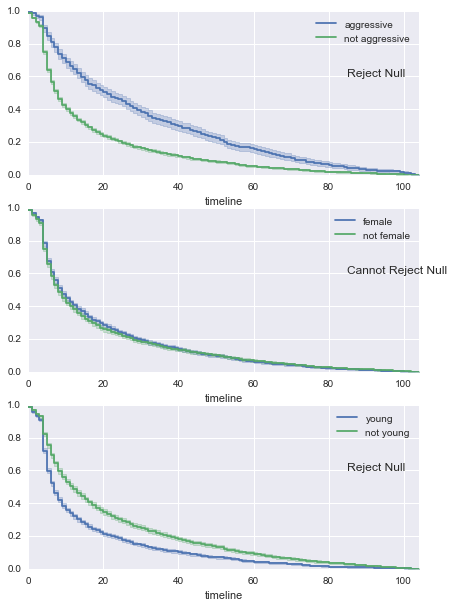

In [195]:
# compare curves by gender, aggression, and age
T = adopt_sub1["shelter_time"]
fig, ax = plt.subplots(3,1, figsize=(7,10))

aggressive = (adopt_sub1["aggressive"] == 1)
female = (adopt_sub1["in_sex"] == 1)
age = (adopt_sub1["age_log"] < log(1.5))

grps = [aggressive, female, age]
labs = ["aggressive", "female","young"]
for grp, lab, ax in zip(grps, labs, ax):
    
    kmf.fit(T[grp],label = lab)
    kmf.plot(ax=ax, ci_force_lines=False)
    kmf.fit(T[~grp], label="not "+lab)
    kmf.plot(ax=ax, ci_force_lines=False)
    
    hypo = logrank_test(T[grp], T[~grp], alpha=.99).test_result
    ax.annotate(hypo, xy=(85,0.6),xytext=(85, 0.6))
plt.ylim(0,1)

No statistical difference between female and male dogs, but young dogs tend to be adopted more quickly, and non-aggressive dogs tend to be adopted more quickly.

(0, 1)

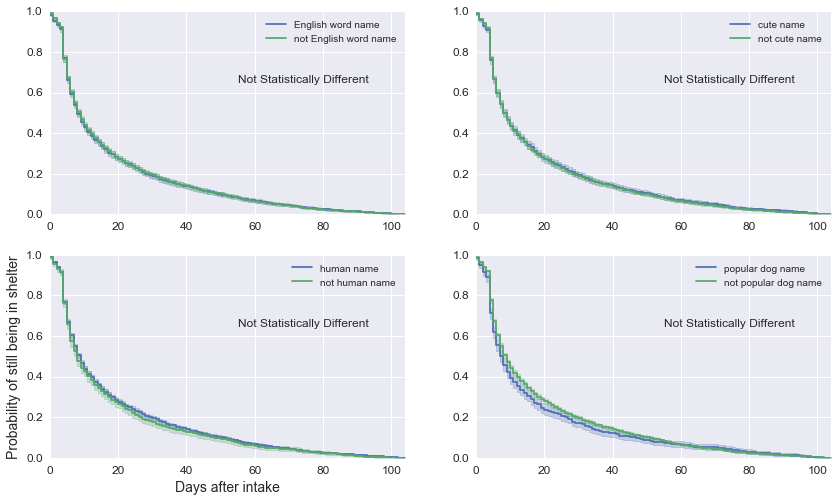

In [196]:
# compare groups by name characteristics
T = adopt_sub1["shelter_time"]
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(14,8))

word = (adopt_sub1["word_name"] == 1)
cute = (adopt_sub1["cute_name"] == 1)
human = (adopt_sub1["human_name"] == 1)
dog = (adopt_sub1["popular_shelter_name"] == 1)


grps = [word, cute, human, dog]
labs = ["English word name", "cute name", "human name", "popular dog name"]
ax = [ax1, ax2, ax3, ax4]
for grp, lab, ax in zip(grps, labs, ax):
    
    kmf.fit(T[grp],label = lab)
    kmf.plot(ax=ax, ci_force_lines=False)
    kmf.fit(T[~grp], label="not "+lab)
    kmf.plot(ax=ax, ci_force_lines=False)
    
    hypo = logrank_test(T[grp], T[~grp], alpha=.99).test_result
    if hypo == "Cannot Reject Null":
        hypo = "Not Statistically Different"
    ax.annotate(hypo, xy=(55,0.65),xytext=(55, 0.65), fontsize=12)
    ax.legend(prop={'size':10})
    ax.set_xlabel("", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
ax3.set_xlabel("Days after intake", fontsize=14)
ax3.set_ylabel("Probability of still being in shelter", fontsize=14)
plt.ylim(0,1)

In [197]:

# check for binary subgroups in which these differences are statistically significant
cols = ['in_sex', 
       'in_neuter','other',  'herding',
       'toy',  'sporting',  
           'aggressive', 
        'Owner Surrender', 'Public Assist', 'Stray',
       'Normal', 'dark mix', 'light', 'light mix',
       3,4,6,11]
for col in cols:
    for i in [0,1]:
        temp = adopt_sub1[adopt_sub[col]==i]
        T = temp["shelter_time"]
        cute = (temp["cute_name"] == 1)
        human = (temp["human_name"] == 1)
        word = (temp["word_name"] == 1)
        pop = (temp["popular_shelter_name"] == 1)
        pop2 = (temp["popular_dog_name"] == 1)

        results = logrank_test(T[cute], T[~cute], alpha=.99 )
        if results.is_significant == True:
            print col, i, "cute", results.p_value
        results = logrank_test(T[human], T[~human], alpha=.99 )
        if results.is_significant == True:
            print col, i, "human", results.p_value
        results = logrank_test(T[word], T[~word], alpha=.99 )
        if results.is_significant == True:
            print col, i, "word", results.p_value
        results = logrank_test(T[pop], T[~pop], alpha=.99 )
        if results.is_significant == True:
            print col, i, "pop", results.p_value
        results = logrank_test(T[pop2], T[~pop2], alpha=.99 )   
        if results.is_significant == True:
            print col, i, "pop2", results.p_value

in_sex 0 pop 0.00348812306586
in_sex 0 pop2 0.00420852980562
Owner Surrender 0 pop 0.00484714353375
Owner Surrender 0 pop2 0.00734840859999
Stray 1 pop 0.00751508333912
dark mix 0 pop 0.00492993148609
light 1 pop 0.00260598187131
4 0 pop 0.00501204834172
4 0 pop2 0.00679499771503


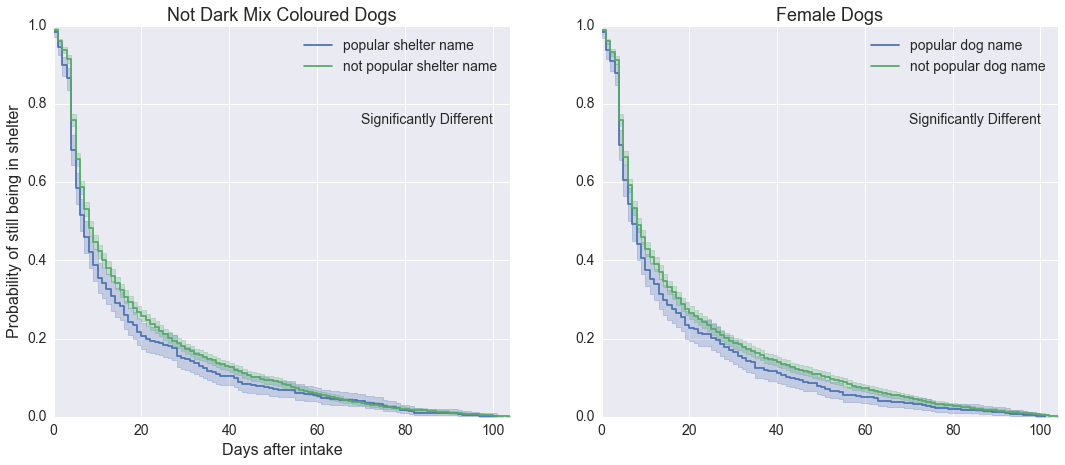

In [198]:
fig, ax = plt.subplots(1,2, figsize=(18,7))
temp = adopt_sub[adopt_sub1["dark mix"]==0]
T = temp["shelter_time"]

pop = (temp["popular_shelter_name"] == 1)

kmf.fit(T[pop],label = "popular shelter name")
kmf.plot(ax=ax[0], ci_force_lines=False)
kmf.fit(T[~pop], label="not popular shelter name")
kmf.plot(ax=ax[0], ci_force_lines=False)

hypo = logrank_test(T[pop], T[~pop], alpha=.99).test_result
if hypo == "Reject Null":
    hypo = "Significantly Different"
ax[0].annotate(hypo, xy=(70,0.75),xytext=(70,0.75),fontsize=14)
ax[0].set_title("Not Dark Mix Coloured Dogs", fontsize=18)
ax[0].set_xlabel("Days after intake", fontsize=16)
ax[0].set_ylabel("Probability of still being in shelter", fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].legend(prop={'size':14})

temp = adopt_sub1[adopt_sub1["in_sex"]==0]
T = temp["shelter_time"]
pop = (temp["popular_dog_name"] == 1)

kmf.fit(T[pop],label = "popular dog name")
kmf.plot(ax=ax[1], ci_force_lines=False)
kmf.fit(T[~pop], label="not popular dog name")
kmf.plot(ax=ax[1], ci_force_lines=False)

hypo = logrank_test(T[pop], T[~pop], alpha=.99).test_result
if hypo == "Reject Null":
    hypo = "Significantly Different"
ax[1].annotate(hypo, xy=(70,0.75),xytext=(70, 0.75), fontsize=14)
ax[1].set_title("Female Dogs", fontsize=18)
ax[1].set_xlabel("", fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].legend(prop={'size':14})

As the two charts above show, the name variables have an impact for certain specific types of dogs.

### Survival Regression

In [199]:

# fit model with low penalty 
aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=True)
aaf.fit(adopt_sub1, 'shelter_time')

 [-----------------100%-----------------] 7256 of 7256 complete in 96.6 sec


<lifelines.AalenAdditiveFitter: fitted with 7256 observations, 0 censored>

In [203]:
aaf_99_10 = AalenAdditiveFitter(alpha=0.99, coef_penalizer=10.0, fit_intercept=True)
aaf_99_10.fit(adopt_sub1, 'shelter_time')

aaf_99_100 = AalenAdditiveFitter(alpha=0.99, coef_penalizer=100.0, fit_intercept=True)
aaf_99_100.fit(adopt_sub1, 'shelter_time')

 [-----------------100%-----------------] 7256 of 7256 complete in 99.6 sec
 [-----------------100%-----------------] 7256 of 7256 complete in 106.7 sec


<lifelines.AalenAdditiveFitter: fitted with 7256 observations, 0 censored>

In [204]:
aaf_99_50 = AalenAdditiveFitter(alpha=0.99, coef_penalizer=50.0, fit_intercept=True)
aaf_99_50.fit(adopt_sub1, 'shelter_time')

aaf_99_200 = AalenAdditiveFitter(alpha=0.99, coef_penalizer=200.0, fit_intercept=True)
aaf_99_200.fit(adopt_sub1, 'shelter_time')

 [-----------------100%-----------------] 7256 of 7256 complete in 91.3 sec
 [-----------------100%-----------------] 7256 of 7256 complete in 88.6 sec


<lifelines.AalenAdditiveFitter: fitted with 7256 observations, 0 censored>

In [205]:
# compare some predictions
pred_line1 = adopt_sub1.iloc[3,:].to_frame()
pred_line1 = pred_line1.drop("shelter_time").T
pred_line1 = pred_line1.applymap(lambda x: float(pd.to_numeric(x)))
pred_line2 = adopt_sub1.iloc[4378,:].to_frame()
pred_line2 = pred_line2.drop("shelter_time").T
pred_line2 = pred_line2.applymap(lambda x: float(pd.to_numeric(x)))
pred_line3 = adopt_sub1.iloc[7210,:].to_frame()
pred_line3 = pred_line3.drop("shelter_time").T
pred_line3 = pred_line3.applymap(lambda x: float(pd.to_numeric(x)))
def print_pred_lines(model):
    fig, ax = plt.subplots(figsize=(8,4))
    model.predict_survival_function(pred_line1).plot(ax=ax, color="red")
    model.predict_survival_function(pred_line2).plot(ax=ax, color="blue")
    model.predict_survival_function(pred_line3).plot(ax=ax, color="green")
    plt.ylim([0,1.03])

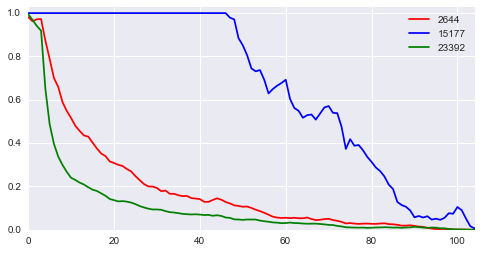

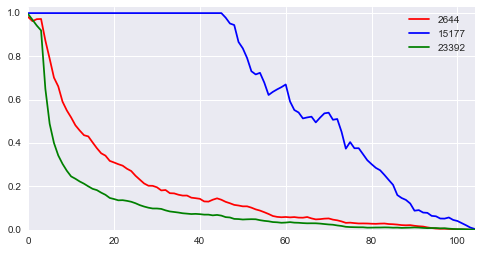

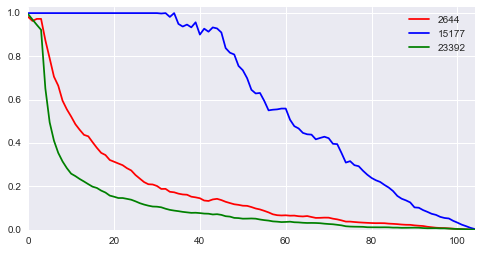

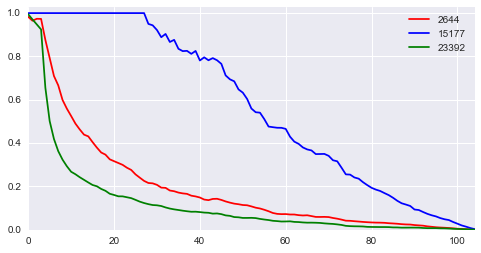

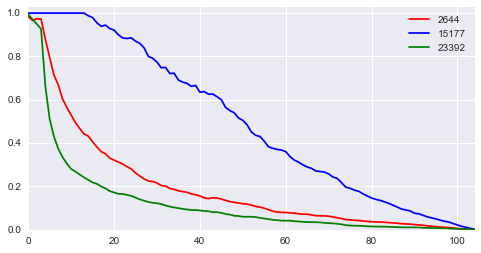

In [210]:
print_pred_lines(aaf)
print_pred_lines(aaf_99_10)
print_pred_lines(aaf_99_50)
print_pred_lines(aaf_99_100)
print_pred_lines(aaf_99_200)

In [216]:
# generate some confidence intervals
cols = pred_line1.index
n, d = pred_line1.shape    
order = aaf_99_200.confidence_intervals_.loc["lower",:].columns
order = order.drop('baseline')
temp = pred_line2[order].values.copy()

temp = np.c_[temp, np.ones((n, 1))]
pred_haz_lower = pd.DataFrame(np.dot(aaf_99_200.confidence_intervals_.loc["lower",:], temp.T), columns=cols)

pred_haz_lower[pred_haz_lower < 0.] = 0.

pred_haz_upper = pd.DataFrame(np.dot(aaf_99_200.confidence_intervals_.loc["upper",:], temp.T), columns=cols)

pred_haz_upper[pred_haz_upper < 0.] = 0.

[(0, 1.2)]

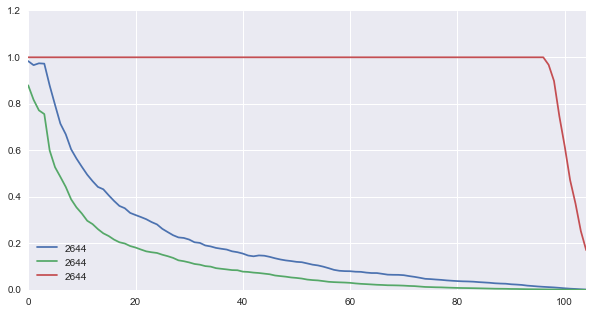

In [217]:
#plot confidence intervals
fig, ax = plt.subplots(figsize=(10,5))
aaf_99_200.predict_survival_function(pred_line1).plot(ax=ax)
np.exp(-pred_haz_upper).plot(ax=ax)
np.exp(-pred_haz_lower).plot(ax=ax)
ax.set(ylim=[0,1.2])

In [255]:
with open('aaf_99_200.pkl', 'w') as picklefile:
    pickle.dump(aaf_99_200, picklefile)
with open('kmf.pkl', 'w') as picklefile:
    pickle.dump(kmf.survival_function_, picklefile)

In [251]:
selector = range(0,100,5)
grp_vals = [round(i,2) for i in kmf.survival_function_.loc[selector,:].values]
print grp_vals